In [1]:
import numpy as np
import torch
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

## Training a classifier

In [2]:
X, y = make_classification(1_000)
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)

test_size = 100

# Prepare train/test sets
test_set_idx = torch.randint(0, X.shape[0], (test_size, ))
idx = torch.ones_like(y, dtype=bool)
idx[test_set_idx] = False

X_test, y_test = X[~idx], y[~idx]
X = X[idx]
y = y[idx]

In [3]:
linear = torch.nn.Linear(20, 2)

In [4]:
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.SGD(linear.parameters(), lr=0.001, momentum=0.9)

epochs = 100

for _ in range(epochs):
    preds = linear(X)
    preds = preds.softmax(1).max(1)[0]
    loss = loss_fn(preds, y.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print("loss: {}\r".format(loss.item()), end="")

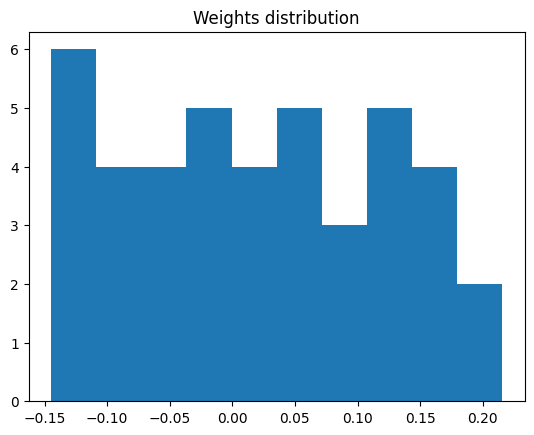

In [5]:
params = torch.concat([x.flatten() for x in linear.parameters()])
params = params.detach().numpy()
plt.hist(params);
plt.title("Weights distribution");

In [6]:
def accuracy(model, d_x, d_y):
    preds = model(d_x).softmax(1).argmax(1)
    score = preds == d_y
    return score.sum() / len(score)

In [7]:
accuracy(linear, X_test, y_test)

tensor(0.3158)

In [8]:
def load_params_in_model(model, params):
    """Helper function to load `params` inside `model`

    **Note**: this method modifes `model` **in place**.
    """
    total_params = len(params)
    params_set = 0
    with torch.no_grad():
        for w_name, w in model.named_parameters():
             # skip un-learnable params
            if not w.requires_grad:
                continue

            setattr(model, w_name, torch.nn.Parameter(
                torch.tensor(params[params_set: params_set + w.numel()],
                             dtype=w.dtype).reshape(w.shape))
            )
            params_set += w.numel()

In [9]:
def metropolis_for_model(model, params_cdf, d_x, d_y, x0, max_iter, burnin=1_000, scale=1.0):
    """

    Args:
    model :
      the model to use to sample `P(D | theta)`.
    params_cdf :
      the cumulative densitify function of the parameter space. This is
      used to `P(theta)` on each new param sample.
    d_x :
      the x dataset to use as D
    d_y :
      the label to use as D
    x0 :
      starting sample for the proposal density
    max_iter :
      the maximum number of iteration of the sampling
    buring :
      the number of sample to discard at the beginning of the sampling phase.
    scale :
      the scale factor to use to "flatten" the probability function. Useful to samples
      values outside the center of the posterior.

    Returns:
      a list of (weight, h(theta)) couples, where h(theta) is defined as:
            log(p(D | theta)) + log(p(theta))
    """
    samples = []
    burnin_count = 0

    backup_model = {
        name: p.clone()
        for name, p in model.named_parameters()
    }
    total_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
    random_noise = stats.norm(0, 1)
    uniform = stats.uniform(-0.1, 0.2)

    def f(new_param):
        load_params_in_model(model, new_param)
        with torch.no_grad():
            p_dataset = model(d_x).softmax(1).gather(1, d_y.unsqueeze(0)).log().sum()
            p_weights = np.log(params_cdf(new_param)).sum()
            return p_dataset + p_weights

    f_x0 = f(x0)

    for _ in range(max_iter):
        # perturbation
        # x_n = x0 + random_noise.rvs(total_param) * 0.1
        x_n = x0 + uniform.rvs(total_param)
        # x_n = stats.multivariate_normal.rvs(x0, 0.5)
        f_xn = f(x_n)   # h(theta) = log(P(D | theta)) + log(P(theta))
        # f_x0 = f(x0)
        # use diff because they're log-prob. Convert it back using 'exp'.
        alpha = np.exp(f_xn - f_x0) * scale
        u = np.random.uniform(0, 1)
        if u <= alpha:
            print(f"Accepting with params: {f_xn=}, {f_x0=}, {alpha=}")
            # accept
            x0 = x_n
            f_x0 = f_xn
            if burnin_count >= burnin:
                samples.append((x_n, f_xn))
            else:
                burnin_count += 1

    # Restore the model
    with torch.no_grad():
        for name, p in backup_model.items():
            setattr(model, name, torch.nn.Parameter(p))

    return samples

In [10]:
# Backup model weights

params = torch.concat([p.flatten() for p in linear.parameters()])
params = params.detach().numpy()

In [11]:
%%time
big_tetha = metropolis_for_model(
    linear,
    stats.norm(-0.2, 0.4).cdf,  # taken from the distribution of trained weights
    X, y,
    # stats.uniform(-0.2, 0.4).rvs(sum(p.numel() for p in linear.parameters() if p.requires_grad)),
    params,  # start searching around the trained model
    10_000,
    burnin=1000,
    scale=0.6,  # flatten the distribution
)

Accepting with params: f_xn=tensor(-753.6553), f_x0=tensor(-793.9651), alpha=tensor(1.9251e+17)
Accepting with params: f_xn=tensor(-706.3381), f_x0=tensor(-753.6553), alpha=tensor(2.1270e+20)
Accepting with params: f_xn=tensor(-646.1495), f_x0=tensor(-706.3381), alpha=tensor(8.2737e+25)
Accepting with params: f_xn=tensor(-641.9973), f_x0=tensor(-646.1495), alpha=tensor(38.1474)
Accepting with params: f_xn=tensor(-641.0546), f_x0=tensor(-641.9973), alpha=tensor(1.5401)
Accepting with params: f_xn=tensor(-640.8036), f_x0=tensor(-641.0546), alpha=tensor(0.7712)
Accepting with params: f_xn=tensor(-641.9055), f_x0=tensor(-640.8036), alpha=tensor(0.1993)
Accepting with params: f_xn=tensor(-640.9108), f_x0=tensor(-641.9055), alpha=tensor(1.6224)
Accepting with params: f_xn=tensor(-640.4437), f_x0=tensor(-640.9108), alpha=tensor(0.9572)
Accepting with params: f_xn=tensor(-640.3748), f_x0=tensor(-640.4437), alpha=tensor(0.6428)
Accepting with params: f_xn=tensor(-641.5062), f_x0=tensor(-640.374

In [12]:
len(big_tetha)

271

## Unlearning

In [13]:
# Generate the erase (or forget) set

to_unlearn = torch.randint(0, len(X), (50, ))
idxs = torch.ones(len(X), dtype=bool)
idxs[to_unlearn] = False
X_r, y_r = X[idxs], y[idxs]
X_e, y_e = X[~idxs], y[~idxs]

In [14]:
X_e.shape, y_e.shape, X_r.shape, y_r.shape

(torch.Size([48, 20]),
 torch.Size([48]),
 torch.Size([857, 20]),
 torch.Size([857]))

In [15]:
def get_numpy_model_params(model, get_only_grads=True):
    """Extract all the weights from `model` as numpy flatten array."""
    params = torch.concat([p.flatten() for p in model.parameters() if get_only_grads and p.requires_grad])
    return params.detach().numpy()

In [16]:
# Find the best scoring model according to the provided forget set.
# The computation find the theta that maximize the following formula:
#        g(theta, D_e) - log(p(D_r))
# which can be simplified as:
#        h(theta) - log(p(D_e | theta))    ; no more D_r, since it's indipendent from theta

largest = -1 * 10 ** 10
old_params = get_numpy_model_params(linear)
max_idx = 0

for idx, (w, h_tetha) in enumerate(big_tetha):
    load_params_in_model(linear, w)
    probs = linear(X_e).softmax(1).gather(1, y_e.unsqueeze(1)).log().sum()
    g = h_tetha - probs
    if g > largest:
        # print("New largest ", g, "at idx", idx)
        largest = g
        max_idx = idx

load_params_in_model(linear, old_params)

In [17]:
load_params_in_model(linear, big_tetha[max_idx][0])

In [18]:
accuracy(linear, X_r, y_r)

tensor(0.5403)

In [19]:
scratch = torch.nn.Linear(20, 2)
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.SGD(linear.parameters(), lr=0.001, momentum=0.9)

epochs = 100

for _ in range(epochs):
    preds = scratch(X_r)
    preds = preds.softmax(1).max(1)[0]
    loss = loss_fn(preds, y_r.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print("loss: {}\r".format(loss.item()), end="")

In [20]:
accuracy(scratch, X_r, y_r)

tensor(0.4761)

In [21]:
def compute_losses(net, d_x, d_y):
    """Auxiliary function to compute per-sample losses"""

    criterion = torch.nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    with torch.no_grad():
            # inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(d_x)
        losses = criterion(logits, d_y).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)


# train_losses = compute_losses(model, train_loader)
# test_losses = compute_losses(model, test_loader)

In [22]:
class Metropolis_Model_Unlearner:
    def __init__(self, model, params_cdf, proposal_fn="normal", delta=0.3):
        # Model info
        self.model = model
        # self._backup_weights = get_numpy_model_params(model, get_only_grads=True)
        self.total_param = sum(p.numel() for p in model.parameters() if p.requires_grad)

        # Metropolis info
        self.params_cdf = params_cdf
        if proposal_fn == "normal":
            self.proposal = stats.norm(0, delta)
        elif proposal_fn == "uniform":
            self.proposal = stats.uniform(-delta, 2*delta)
        else:
            raise ValueError("invalid proposal fn '{}'".format(proposal_fn))
        assert self.proposal is not None
        # self.noise = stats.norm(0, 0.3)  # also valid stats.uniform(-0.1, 0.2)
        self.steps = 0


    def generate_best_model(self, d_x, d_y, e_x, e_y, early_stopping=100, scale=1.0):
        best_score = -1 * 10 ** 10

        x0 = get_numpy_model_params(self.model)
        f_x0 = self.h_function(x0, d_x, d_y)
        best_weight = x0

        stop = 0
        while stop <= early_stopping:
            stop += 1
            self.steps += 1

            x_n = x0 + self.proposal.rvs(self.total_param)
            f_xn = self.h_function(x_n, d_x, d_y)

            alpha = np.exp(f_xn - f_x0) * scale

            u = np.random.uniform(0, 1)  # @Speed: precompute
            if u <= alpha:
                # print("   debug: improving")
                # Accept
                x0 = x_n
                f_x0 = f_xn
                # Find if this is a suitable value for the erase set.
                with torch.no_grad():
                    e_prob = self.model(e_x).softmax(1).gather(
                        1, e_y.unsqueeze(1)).log().sum()
                    g = f_xn - e_prob
                if g > best_score:
                    print("  DEBUG: new best score", g)
                    best_score = g
                    best_weight = x_n
                    stop = 0

        return best_weight, best_score


    def h_function(self, theta, d_x, d_y):
        load_params_in_model(self.model, theta)
        with torch.no_grad():
            p_dataset = self.model(d_x).softmax(1).gather(1, d_y.unsqueeze(1)).log().sum()
            p_weights = np.log(self.params_cdf(theta)).sum()
            return p_dataset + p_weights


In [23]:
load_params_in_model(linear, params)

In [24]:
m = Metropolis_Model_Unlearner(
    linear,
    stats.uniform(-0.2, 0.4).cdf,
    proposal_fn="normal",
    delta=0.05,
)

In [25]:
best_weight, score = m.generate_best_model(X_r, y_r, X_e, y_e, early_stopping=20_000, scale=0.7)

/tmp/ipykernel_7918/118471589.py:62: RuntimeWarning: divide by zero encountered in log
  p_weights = np.log(self.params_cdf(theta)).sum()


  DEBUG: new best score tensor(-686.7079)
  DEBUG: new best score tensor(-636.9696)
  DEBUG: new best score tensor(-622.7790)
  DEBUG: new best score tensor(-611.2457)
  DEBUG: new best score tensor(-578.1829)
  DEBUG: new best score tensor(-558.7150)
  DEBUG: new best score tensor(-546.1091)
  DEBUG: new best score tensor(-527.3767)
  DEBUG: new best score tensor(-506.7711)
  DEBUG: new best score tensor(-491.4445)
  DEBUG: new best score tensor(-488.1906)
  DEBUG: new best score tensor(-483.3107)
  DEBUG: new best score tensor(-469.2409)
  DEBUG: new best score tensor(-457.1782)
  DEBUG: new best score tensor(-434.6732)
  DEBUG: new best score tensor(-430.7705)
  DEBUG: new best score tensor(-413.5713)
  DEBUG: new best score tensor(-410.4002)
  DEBUG: new best score tensor(-401.7427)
  DEBUG: new best score tensor(-397.4849)
  DEBUG: new best score tensor(-393.6765)
  DEBUG: new best score tensor(-385.5323)
  DEBUG: new best score tensor(-377.8654)
  DEBUG: new best score tensor(-37

In [26]:
best_weight, score

(array([3.87744142, 2.46639348, 1.214464  , 2.71645984, 3.10896223,
        3.41630694, 2.74614609, 2.39566966, 3.93139955, 3.49908288,
        1.68172047, 1.17362182, 2.47525358, 3.32265605, 0.49085358,
        3.10161943, 3.22551122, 2.24575924, 1.05294824, 5.25658756,
        4.11802572, 2.36878685, 1.26063794, 3.94478949, 0.76009825,
        3.47250808, 2.89487809, 2.30942479, 3.9462162 , 3.42205509,
        1.48757186, 1.10409852, 2.44866083, 3.32356518, 0.32311808,
        5.50217258, 3.62810702, 2.3797927 , 0.98388338, 5.30626374,
        2.11348585, 2.34852993]),
 tensor(-253.9244))

In [27]:
m.steps

73883

In [28]:
load_params_in_model(linear, best_weight)

In [29]:
accuracy(linear, X_r, y_r)

tensor(0.8658)

In [30]:
accuracy(scratch, X_r, y_r)

tensor(0.4761)

## Experiments for the Hamiltonian MC (HMC)

In [15]:
# Taken from https://github.com/martin-marek/mini-hmc-jax/blob/main/hmc.py

import jax
import jax.numpy as jnp


def leapfrog(params, momentum, log_prob_fn, step_size, n_steps):
    """Approximates Hamiltonian dynamics using the leapfrog algorithm."""

    # define a single step
    def step(i, args):
        params, momentum = args
        
        # update momentum
        grad = jax.grad(log_prob_fn)(params)
        momentum += 0.5 * step_size * grad

        # update params
        params += momentum * step_size

        # update momentum
        grad = jax.grad(log_prob_fn)(params)
        momentum += 0.5 * step_size * grad
        
        return params, momentum

    # do 'n_steps'
    new_params, new_momentum = jax.lax.fori_loop(0, n_steps, step, (params, momentum))

    return new_params, new_momentum


def sample(params, log_prob_fn, n_steps, n_leapfrog_steps, step_size, key):
    """
    Runs HMC and returns the full Markov chain as a list.
    - params: array
    - log_prob_fn: function that takes params as the only argument and returns a scalar value
    """

    # define a single step
    def step(i, args):
        params, chain, total_accept_prob, key = args
        key, normal_key, uniform_key = jax.random.split(key, 3)

        # generate random momentum
        momentum = jax.random.normal(normal_key, shape=params.shape)

        # leapfrog
        new_params, new_momentum = leapfrog(params, momentum, log_prob_fn, step_size, n_leapfrog_steps)

        # MH correction
        potentaial_energy_diff = log_prob_fn(new_params) - log_prob_fn(params)
        kinetic_energy_diff = 0.5*(momentum**2 - new_momentum**2).sum()
        log_accept_prob = potentaial_energy_diff + kinetic_energy_diff
        log_accept_prob = jnp.nan_to_num(log_accept_prob, nan=-jnp.inf)
        accept_prob = jnp.minimum(1, jnp.exp(log_accept_prob))
        total_accept_prob += accept_prob
        accept = jax.random.uniform(uniform_key) < accept_prob
        params = jnp.where(accept, new_params, params)
        
        # store params
        chain = chain.at[i].set(params)
         
        return params, chain, total_accept_prob, key
    
    # do 'n_steps'
    chain = jnp.zeros([n_steps, len(params)])
    _, chain, total_accept_prob, key = jax.lax.fori_loop(0, n_steps, step, (params, chain, 0, key))
    
    print(f'Avg. accept. prob.: {(total_accept_prob/n_steps):.2%}')
    return chain

In [16]:
# define target distribution
def target_log_pdf(params):
    return jax.scipy.stats.t.logpdf(params, df=1).sum()

# run HMC
params_init = jnp.zeros(10)
key = jax.random.PRNGKey(0)
chain = sample(
    params_init,
    target_log_pdf,
    n_steps=10,
    n_leapfrog_steps=100,
    step_size=0.1,
    key=key
)

Avg. accept. prob.: 99.43%


In [23]:
jax.random.split(key, 3)

Array([[2467461003,  428148500],
       [3186719485, 3840466878],
       [2562233961, 1946702221]], dtype=uint32)

In [49]:
sample = torch.rand_like(X)
y_hat = linear(sample).max(axis=1)[0]
grad = torch.autograd.grad(y_hat[0], linear.parameters(), create_graph=False, )

In [56]:
grad[0][grad[1].argmax()]

tensor([0.7636, 0.3352, 0.7362, 0.6920, 0.3123, 0.2430, 0.2489, 0.0351, 0.6320,
        0.0354, 0.4619, 0.4316, 0.9835, 0.0685, 0.7778, 0.7311, 0.7433, 0.4512,
        0.6874, 0.2272])

In [40]:
grad

(tensor([[435.4507, 464.1140, 458.1435, 440.4112, 444.0208, 453.4189, 457.2523,
          465.1400, 452.8130, 453.8045, 449.2015, 438.1946, 453.3444, 448.9147,
          456.7658, 449.6122, 443.3095, 446.7079, 457.8015, 461.5858],
         [435.4507, 464.1140, 458.1435, 440.4112, 444.0208, 453.4189, 457.2523,
          465.1400, 452.8130, 453.8045, 449.2015, 438.1946, 453.3444, 448.9147,
          456.7658, 449.6122, 443.3095, 446.7079, 457.8015, 461.5858]]),
 tensor([905., 905.]))

## Unlearning quality check

In [43]:
from sklearn import linear_model, model_selection

def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

In [45]:
load_params_in_model(linear, best_weight)
forget_losses = compute_losses(linear, X_e, y_e)
test_losses   = compute_losses(linear, X_test, y_test)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
np.random.shuffle(forget_losses)
forget_losses = forget_losses[: len(test_losses)]

samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)

mia_scores = simple_mia(samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.667 on forgotten vs unseen images


In [ ]:
load_params_in_model(linear, params)
forget_losses = compute_losses(linear, X_e, y_e)
test_losses   = compute_losses(linear, X_test, y_test)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
np.random.shuffle(forget_losses)
forget_losses = forget_losses[: len(test_losses)]

samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)

mia_scores = simple_mia(samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images"
)

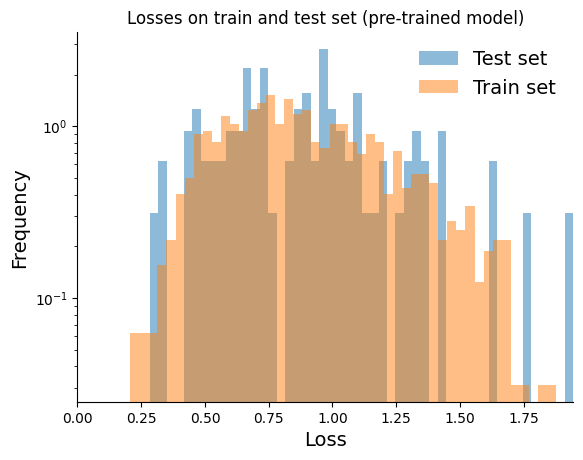

In [238]:
# plot losses on train and test set
plt.title("Losses on train and test set (pre-trained model)")
plt.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
plt.hist(train_losses, density=True, alpha=0.5, bins=50, label="Train set")
plt.xlabel("Loss", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim((0, np.max(test_losses)))
plt.yscale("log")
plt.legend(frameon=False, fontsize=14)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

In [287]:
%%time
got = metropolis(stats.expon().pdf, 1, 10_000)

CPU times: user 908 ms, sys: 3.05 ms, total: 911 ms
Wall time: 908 ms


(array([1384., 1099.,  722.,  417.,  228.,  129.,   77.,   37.,   26.,
           7.]),
 array([1.26711443e-03, 5.96117737e-01, 1.19096836e+00, 1.78581898e+00,
        2.38066960e+00, 2.97552023e+00, 3.57037085e+00, 4.16522147e+00,
        4.76007210e+00, 5.35492272e+00, 5.94977334e+00]),
 <BarContainer object of 10 artists>)

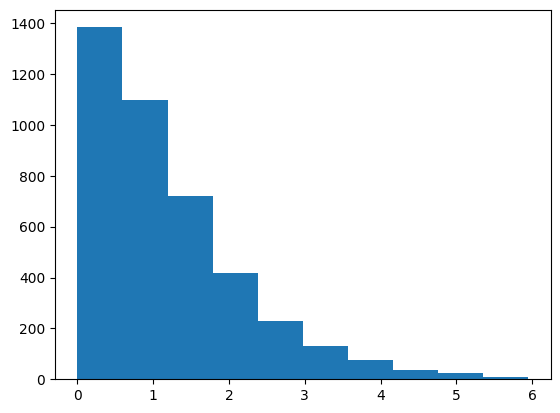

In [288]:
plt.hist(got)

In [224]:
stats.ks_1samp(stats.norm(0, 1).rvs(1), stats.norm(0, 1).cdf)

KstestResult(statistic=0.9573664795009253, pvalue=0.0852670409981493, statistic_location=-1.720910637454097, statistic_sign=1)